# Tutorial 1: Basic Setup and Simulation

## Introduction to the Project

In this tutorial, we will set up, mesh, and simulate a basic membrane using the particle model. The aim is to provide an introductionLightSailSim. 

Objectives:
1. Generate and modify meshes for particle systems.
2. Initialize and configure the particle system.
3. Set up optical forces and laser beams.
4. Run simulations and analyze resu
tions.sers.

Let's get started by setting up the necessary modules and parameters for otions.
ur simulation.


In [1]:
# Setup and Parameters

# Importing necessary modules
import sys, os
import time
import logging
import copy
from collections import defaultdict
from typing import Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.constants import c
from scipy.interpolate import griddata
from scipy.interpolate import interp1d

# Add the src directory to the system path for imports
sys.path.append(os.path.abspath('..'))

# LLS specific imports
from src.particleSystem.ParticleSystem import ParticleSystem
from src.Sim.simulations import Simulate_Lightsail
import src.Mesh.mesh_functions as MF
import src.ExternalForces.optical_interpolators.interpolators as interp
from src.ExternalForces.LaserBeam import LaserBeam
from src.ExternalForces.OpticalForceCalculator import OpticalForceCalculator
from src.ExternalForces.OpticalForceCalculator import ParticleOpticalPropertyType
from src.ExternalForces.optical_interpolators import create_interpolator_specular

### Define Parameters

Here, we define the parameters for the simulation. These parameters include:
- **Model parameters**: Properties like damping coefficient, mass of each node, thickness, and density.
- **Simulation settings**: Parameters controlling the simulation timestep, convergence thresholds, and solver settings.
- **Mesh-dependent settings**: Parameters that influence the mesh configuration.




In [2]:
# Dictionary of required parameters
# Define simulation parameters
params = {
    # Model parameters
    "c": 1,  # [N s/m] damping coefficient
    "m_segment": 1,  # [kg] mass of each node
    "thickness": 200e-9,  # [m] thickness of PhC
    "rho": 3184,  # [kg/m^3] Density of SiN
    
    # Simulation settings
    "dt": 2e-3,  # [s] simulation timestep
    'adaptive_timestepping': 2.5e-4,  # [m] max distance traversed per timestep
    "t_steps": 1e3,  # [-] max number of simulated time steps
    "abs_tol": 1e-20,  # [m/s] absolute error tolerance iterative solver
    "rel_tol": 1e-5,  # [-] relative error tolerance iterative solver
    "max_iter": int(1e2),  # [-] maximum number of iterations for the bicgstab solver
    
    # Simulation Steps
    "convergence_threshold": 5e-7,  # Metric depends on size of timestep. Have to update them together.
    "min_iterations": 30,  # Should exceed the size of the force ring buffer in the simulation loop
}

## Meshing

For this tutorial, we will simulate a rectangular grid for the membrane. We will use the `mesh_square` function from `mesh_functions` to create the mesh.
First we have to add some physical constants to the params file, this will then allow the mesher to set the springs to the correct. We can immediately adjust them to reflect that the PhC is mostly empty space as well. nits.
h.


In [3]:
params['E'] = 470e6
params['G'] = 0
params['E_x'] = params['E'] * (259 + 351) / 1991 # stiff direction
params['E_y'] = params['E'] * 5 / 100 # not-so-stiff direction

fill_factor = 0.43
params['rho'] *= fill_factor

### Mesh Generation

In this section, we generate the mesh for the particle system. The mesh defines the spatial configuration of particles and their connections. Here’s what we do:

1. **Generate initial mesh**: Using the `mesh_round_phc_square_cross` function to create a round lightsail with a square cross patterned mesh.
    - Because `params['G'] = 0`, the diagonal links are automatically omitted.
2. **Fix edge particles**: Ensure that edge particles are correctly identified and fixed if necessary.
3. **Add support structure**: Introduce additional particles and links to act as a support structure, ensuring stability and accuracy in simulations.

The mesh is a critical component that defines the structure and connectivity of the particles in the system.
tem.
.


In [4]:
# Generate the mesh
n_segments = 11  # Make sure this is uneven so there are no particles on the centerline
radius = 0.5  # [m]
length = 2 * radius
fixed_edge_width = radius / n_segments * 2 # thickness of the region from the outside in to fix

mesh = MF.mesh_phc_square_cross(length,
                                mesh_edge_length=length / n_segments,
                                params=params,
                                noncompressive=True,
                                fix_outer=True)

Okay, but what if we want to add some more structure, such as a compliant ring around the outside of the membrane? We can totally do that, but it requires some more work. 

First, we will define the stiffness of the ring and calculate the stiffness of the resulting springs. 

In [5]:
# Add some particles to act as a support structure
stiffness_support = 5.93E+07  # [N/m*m] line stiffness

n_fixed = sum([i[3] for i in mesh[1]])
circumference = 2 * np.pi * radius
k_support = stiffness_support * (circumference / n_fixed)
l_support = length / n_segments 
multiplier = (radius + l_support) / radius

Then we can manually dig through the mesh parameters, set the currently fixed ring particles to be able to move in the x-y plane and then add the new nodes.

In [6]:
new_particles = []
for i, node in enumerate(mesh[1]):
    xyz = node[0].copy()
    if node[3]:
        node.append([0, 0, 1]) # Define orientation of constraint
        node.append('plane') # Define type of constraint
        particle = [xyz * multiplier, np.zeros(3), params['m_segment'], True]
        link = [i, len(mesh[1]) + len(new_particles), k_support, 1]
        new_particles.append(particle)
        mesh[0].append(link)

for p in new_particles:
    mesh[1].append(p)

## Initialise the Particle System
Now that we have amended our mesh we can init the particle system and inspect our handiwork. There are now a couple of convenience functions for plotting, that we will use throughout the tutorial to visualise the PS.

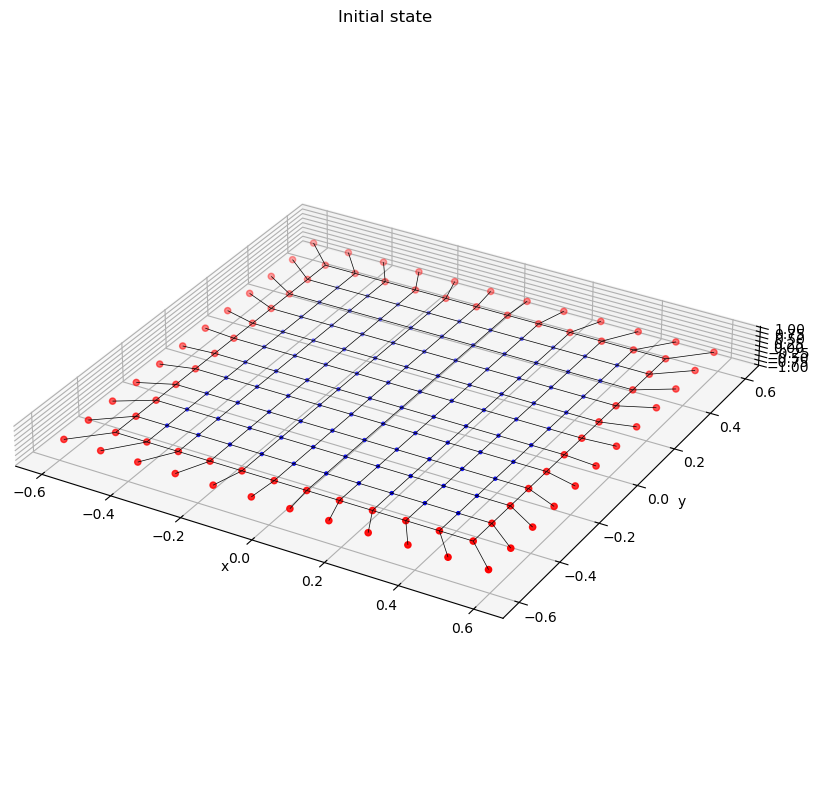

In [7]:
PS = ParticleSystem(*mesh, params) # the * operator unpacks the mesh into the two sublists
fig = plt.figure(figsize = [12,8])
ax = fig.add_subplot(projection = '3d') 
ax = PS.plot(ax)
ax.set_zlim(-1, 1)
ax.set_title("Initial state")
fig.tight_layout()

While we're at it, we might also want to set the correct masses in the PS based on the information we put in the parameters file:

In [8]:
PS.calculate_correct_masses(params['thickness'], params['rho'])
print(f"Total mass: {sum([p.m for p in PS.particles])*1e3:.3g} [g]")

Total mass: 0.382 [g]


Now, let's say that there is some thermal pre-stress in the sail? We can model that by scaling down the resting lengths of the SpringDamper elements the right amount:


In [9]:
# Adding pre_stress
pre_stress = 3e6 # [Pa]
pre_strain = pre_stress / max(params['E_x'],params['E_y'])
shrink_factor = 1/(1+pre_strain)
PS.stress_self(shrink_factor)

# Optical system 
Okay! That's all on the mechanical side. Next up is setting up the optical side. Broadly, we will associate an 'optical type' with each particle. For the optical type defining Photonic crystals, we will also have to include the right interpolator to represent its behaviour.
Let's split the sail into 5 regions: a circular central section that is specularly reflective, and four outer portions that have an associated PhC. 

## Importing and Assigning a Photonic Crystal (PhC)

In this section, we will import a Photonic Crystal (PhC) and assign it to the particles in our mesh. This will involve using the `interpolators` module from the `optical_interpolators` subpackage.

### Step 1: Import the Photonic Crystal Data

First, we need to import the necessary modules and load the PhC data.


In [10]:
# import the photonic crystal(s)
gao = interp.PhC_library['Mark_4']
specular = create_interpolator_specular()
offset = np.pi
#            phi_start,  phi_stop,   r_start,    r_stop,  midline,   PhC,        rotational offset
regions = [[0,          np.pi*2,    0,          length/3, np.pi*1/4, specular, offset],
           [0,          np.pi/2,    length/3,   length*2,   np.pi*1/4, gao,      offset],
           [np.pi/2,    np.pi,      length/3,   length*2,   np.pi*3/4, gao,      offset],
           [np.pi,      np.pi*3/2,  length/3,   length*2,   np.pi*5/4, gao,      offset],
           [np.pi*3/2,  np.pi*2,    length/3,   length*2,   np.pi*7/4, gao,      offset]]

for reg in regions:
    if type(reg[5])==str:
        reg[5] = interp.create_interpolator(reg[5], reg[4]+reg[6]) # Set interpolator with the right rotation

### Step 2: Assign the PhC to Particles

Next, we will assign the PhC properties to the particles in our mesh. We will iterate over the particles and set their optical properties using the loaded PhC dat.


In [11]:
# Now we apply them to the PS
for p in PS.particles:
    x,y,z = p.x
    phi = np.arctan2(y,x)%(2*np.pi)
    r = np.linalg.norm(p.x)
    for reg in regions:
        if r >= reg[2] and r <= reg[3] and phi <= reg[1] and phi >= reg[0]:
            if reg[5] == ParticleOpticalPropertyType.SPECULAR:
                p.optical_type = ParticleOpticalPropertyType.SPECULAR
            else:
                p.optical_type = ParticleOpticalPropertyType.ARBITRARY_PHC
                p.optical_interpolator = reg[5]

### Step 3: Set up the LaserBeam
And now we can initialise the optical force calculator as well.

In [12]:
# init optical system
P = 200e5# [W]

# if you want to check, set it all to specular and set sigma to radius/3
# net force should be P_original/c*2*2 (*2 for reflection, *2 for the second laser)
mu_x = 0
mu_y = 0
sigma = radius*1
I_0 = 2*P / (np.pi* sigma**2)

LB = LaserBeam(lambda x, y: I_0 * np.exp(-1/2 *((x-mu_x)/sigma)**2 # gaussian laser
                                         -1/2 *((y-mu_y)/sigma)**2),
               lambda x,y: np.outer(np.ones(x.shape),[1,1]))
OFC = OpticalForceCalculator(PS, LB)

## Step 4: Check the forces
Let's visualise the optical forces to see if we did it right!

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

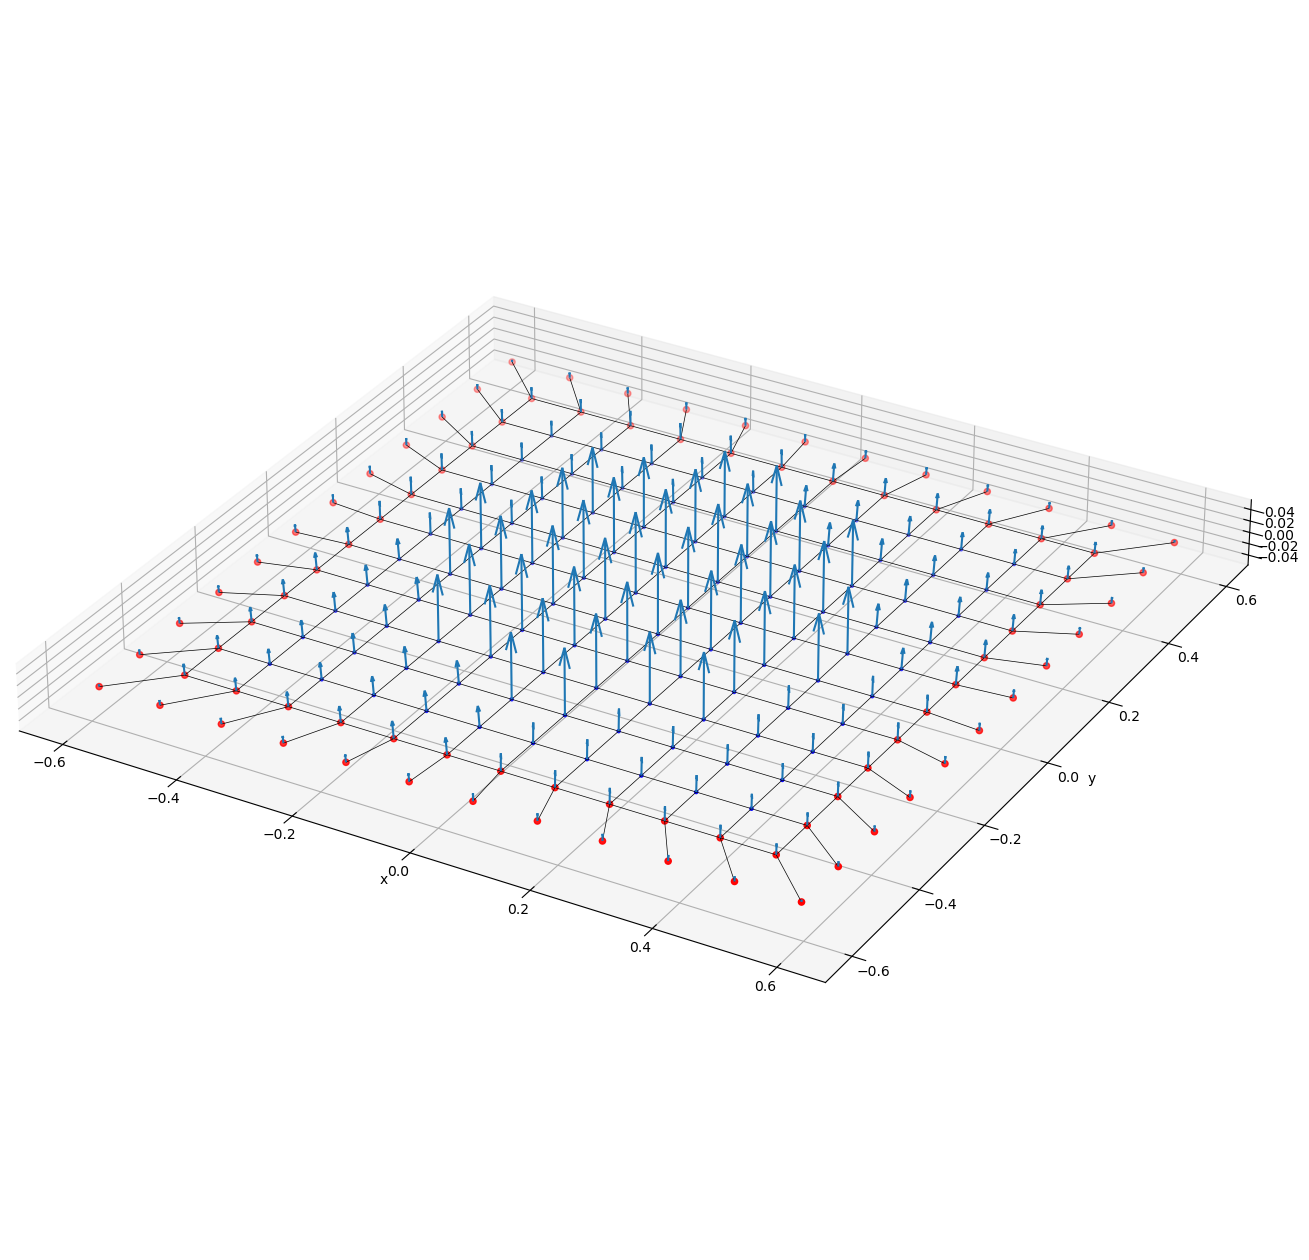

In [13]:
forces = OFC.force_value()
fig = plt.figure(figsize = [16,20])
ax = fig.add_subplot(projection = '3d') 
PS.plot_forces(forces, ax=ax, length = 5e1)

That seems to have worked pretty well! Let's simulate it!

# Simulating a Lightsail
To do so, we can initialise an instance of the `Simulate` class, in this case `Simulate_Lightsail`. This has everything built in to perform simple simulations. If you have more refined needs you can write your version based on it! 

It needs the Particle System, the Optical Force Calculator and the params dictionary to initialise it. We make use of the three defined methods:

- `run_simulation`: Runs a simulation of the sail deformation until the convergence criterion in the params dictionary has been met.
- `simulate_trajectory`: Runs a trajectory simulation, with the option to turn the deformation simulation off and on if needed.
- `plot_flight_hist`: plots the flight trajectory after simulation.

Let's first see what the sail deformation is like for this configuration.

In [14]:
SIM = Simulate_Lightsail(PS, OFC, params)

SIM.run_simulation(
    simulation_function = 'kinetic_damping',
    printframes = 50)

step=0, 	t=0m 0.07s, 	crit=0, 	z_max=8.863e-11, 	net_force=0.18, 	dt=0.00027
step=50, 	t=0m 3.42s, 	crit=5.18e-05, 	z_max=0.01094, 	net_force=0.18, 	dt=1.9e-05
step=100, 	t=0m 7.11s, 	crit=8.09e-05, 	z_max=0.02344, 	net_force=0.19, 	dt=3.1e-05
step=150, 	t=0m 11.87s, 	crit=0.000187, 	z_max=0.03594, 	net_force=0.18, 	dt=0.00011
step=200, 	t=0m 15.40s, 	crit=7.92e-05, 	z_max=0.04206, 	net_force=0.18, 	dt=0.0016
step=236, 	t=0m 18.09s, 	crit=6.52e-08, 	z_max=0.04278, 	net_force=0.18, 	dt=0.002
Converged in 0m 18.09s, 237 timesteps


Okay, let's see how much it bulged!

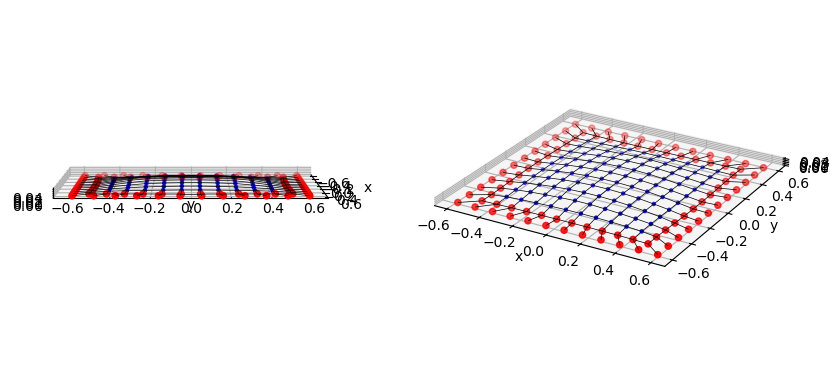

In [15]:
fig = plt.figure(figsize=[10,20])
ax1 = fig.add_subplot(121, projection='3d')
PS.plot(ax1)
ax1.azim = 0
ax1.elev = 5
ax2 = fig.add_subplot(122, projection='3d')
PS.plot(ax2)
ax2.elev = 25

Now we can simulate it, and for simplciity we will assume that it will not deform anymore after this point in time. 

step=10, 	t=0m 0.20s, 	abs_force=0.18, 	dt=0.002, 	location=([-0.0009, -0.    ]) [D], 	angles=([ 0.003, -0.016,  0.   ]) [deg], 	E_kin_xy=2.1e-06, 	E_kin_rot=8.1e-05
step=20, 	t=0m 0.42s, 	abs_force=0.18, 	dt=0.002, 	location=([-0.0037, -0.0001]) [D], 	angles=([ 0.016, -0.089,  0.   ]) [deg], 	E_kin_xy=8.8e-06, 	E_kin_rot=0.00086
step=30, 	t=0m 0.62s, 	abs_force=0.18, 	dt=0.002, 	location=([-0.0082, -0.0003]) [D], 	angles=([ 0.061, -0.297,  0.   ]) [deg], 	E_kin_xy=1.8e-05, 	E_kin_rot=0.0058
step=40, 	t=0m 0.84s, 	abs_force=0.18, 	dt=0.002, 	location=([-0.0142, -0.0009]) [D], 	angles=([ 0.193, -0.802,  0.   ]) [deg], 	E_kin_xy=3e-05, 	E_kin_rot=0.028
step=50, 	t=0m 1.03s, 	abs_force=0.18, 	dt=0.002, 	location=([-0.0219, -0.0016]) [D], 	angles=([ 0.41 , -2.067,  0.   ]) [deg], 	E_kin_xy=4.7e-05, 	E_kin_rot=0.17
step=60, 	t=0m 1.22s, 	abs_force=0.17, 	dt=0.002, 	location=([-0.0311, -0.0015]) [D], 	angles=([ 0.693, -5.33 ,  0.   ]) [deg], 	E_kin_xy=6.8e-05, 	E_kin_rot=1
Simulation halted:

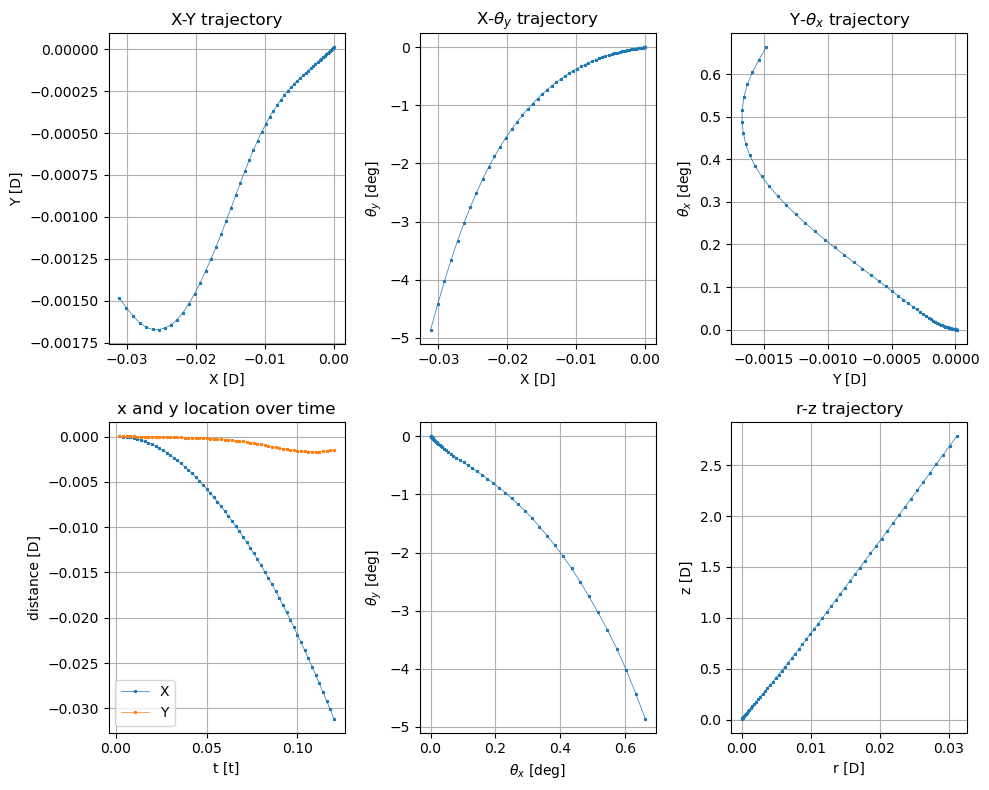

In [16]:
# need to do this because if the traj. sim. runs longer than the previous one it throws an error.
PS.reset_history() 
SIM.simulate_trajectory(
    deform = False,
    spin = False)

SIM.plot_flight_hist()

So that's it! It is unstable! Better luck next sail!